# Sentence Generator for Nigerian Indigenous Languages

# Load Data from Git URL

Yoruba Proverb Generator with stopwords & LSTM with 400 nodes

In [1]:
# Import neccessary libraries
#!pip install tensorflow to run this code
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import re

In [2]:
# Testing if GPU is active
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# Import Data from url
!wget https://raw.githubusercontent.com/Niger-Volta-LTI/yoruba-text/master/Owe/owe.txt

--2022-09-02 21:40:08--  https://raw.githubusercontent.com/Niger-Volta-LTI/yoruba-text/master/Owe/owe.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180836 (177K) [text/plain]
Saving to: ‘owe.txt’

owe.txt             100%[===================>] 176.60K  --.-KB/s    in 0.002s  

2022-09-02 21:40:09 (99.1 MB/s) - ‘owe.txt’ saved [180836/180836]



In [4]:
# Load data
with open("owe.txt", "r") as file:
  data = file.readlines()
  # using regular expression to remove punctuations from each line
  data = re.sub(r"[^\w\s]","",''.join(data)).lower().split('\n')
  #data = ''.join(data).lower().split('\n')
del data[0]
del data[-1]
print(len(data))
data[:2]

2700


['a di gàárì sílẹ ewúrẹ ńyọjú ẹrù ìran rẹ ni',
 'a kì í dàgbà má làáyà ibi ayé bá báni là ńjẹ ẹ']

## Data Preprocessing(Removing Stopwords, Tokenization, Case folding, Sequencing and Sequence Padding)

In [5]:
df = pd.DataFrame(data, columns=['owe'])
df.head()

,owe
0,a di gàárì sílẹ ewúrẹ ńyọjú ẹrù ìran rẹ ni
1,a kì í dàgbà má làáyà ibi ayé bá báni là ńjẹ ẹ
2,àgbà kán ṣe bẹẹ lógùn yemaja ló gbé e lọ
3,ibi tí oyín gbé ńhó tí àdó ńhó ìfun ò dákẹ lásán
4,ìdí òwò ni òwòó gbé tà


In [6]:
# # Import some yoruba stopwords 
# !wget https://raw.githubusercontent.com/stopwords-iso/stopwords-yo/master/raw/gh-stopwords-json-yo.txt

In [7]:
# # Load yoruba stopwords data
# with open("gh-stopwords-json-yo.txt", "r") as file:
#   yor_stw1 = file.readlines()
#   yor_stw1 = ''.join(yor_stw1).lower().split('\n')
# len(yor_stw1)

In [11]:
# # other yoruba stopwords gotten from the research paper below
# # https://www.researchgate.net/publication/329424324_Entropy-Based_Generic_Stopwords_List_for_Yoruba_Texts
# stpwords = ["tí, ni, wọn, àwọn, tó, pé, ń, ṣe, náà, ó, kò, sí, bá, wá, fi, kí, lọ, yìí, kan, a, jẹ́, sì, fún, ti, bí, yóò, sọ, àti, rẹ, \
# láti, wó ̣n, ẹ, ní, í, ló, máa, òun, gbà, nínú, rí, gbogbo, nígbà, \
# lè, ọmọ, gbé, ọ̀rọ̀, èyí, mo, mọ, mọ́, rẹ̀, di, ọ̀hún, bẹ́ẹ̀, tún, nǹkan, ar a, nítorí, ṣùgbọ́n, lọ́wọ́, mú, dá, lórí, ẹni, ọwọ́, bíi, jù, pẹ̀lú, \
# ọjọ́, mi, sílẹ̀, iṣẹ́, bó, ohun, kó, un, dé, báyìí, pa, níbẹ̀, ibi, wà, ká, tàbí, láàrin, yẹ, gbọ́ , làwọn, bẹ̀rẹ̀, má, ìyẹn, \
# kú, ìgbà, kọjá, lóun, eré, ọnà, pọ̀, àsìkò, jáde, gẹ́gẹ́, jọ, á, i, sọ̀rọ̀, fẹ́, irú, kúrò, bọ̀, o, le, lára, wáá, níbi, lẹ́yìn, wò, \
# wo, nípa, ín, inú, méjì, nílé, yín, ọn, ńkọ́, ńlá, já, déédé, la, tẹ, rárá, ìdí, òpin, ṣeé, lọ́jọ́, lọ́sẹ̀, títí, wáyé, ò, padà, án, \
# lójú, tẹ́lẹ̀, rò, gan, tàwọn, tán, rán, tòun, lọọ, ẹ̀yin, ọ̀dọ̀, wa, tóó, ṣẹbọ, kọ́kọ́, ta, sá, n, yọ, dúró, hàn, \
# ṣiṣẹ́, lọ́dún, kì, lẹ, ṣẹlẹ̀, pàápàá, nílùú, nìkan, níṣẹ́, síbẹ̀, nìyẹn, yẹn, kankan, bóyá, múra, fáwọn, e, lọ́nà, yá, gbọ́dọ̀, \
# lẹ́nu, wàhálà, wí, káàkiri, parí, síbi, kọ, mẹ́ta, ọ̀kan, kẹta, san, péré, dáadáa, láìpẹ́, wọlé, sùn, tilẹ̀, lélẹ̀, ẹnikẹ́ni, á, \
# ẹnìkan, èmi, ọ̀pọ̀, mẹ́rin, peléke, nídìí, wẹ́wẹ́, ún, méjìlá, kínní, ú, sínú, sáré, kín, yàrá, fúnra, kọjú, díẹ̀, lòótọ́, nìyí, àtàwọn, bákan, \
# méjèèjì, fẹ̀gbẹ́, àbí, kiri, torí, jẹ, káwọn, márún, jùlọ, ọ̀pọ̀lọpọ̀, síwájú, àgàgà, lásán, tọ, tètè, àwa, odidi, pàdé, tiẹ, \
# tuntun, gba, sọ́dọ̀, kàn, yí, ọ, mìíràn, wọ̀nyí, ná, ọ́, ẹ́, afi"]

In [12]:
# split the words 
# yor_stw2 = [each.split(', ') for each in stpwords]
# yor_stw2 = yor_stw2[0]
# len(yor_stw2)

In [13]:
# # merging the two lists of yoruba stopwords together without repetition
# def Union(lst1, lst2):
#     final_list = list(set(lst1) | set(lst2))
#     return final_list
# yor_stopwords_ = Union(yor_stw1, yor_stw2)
# len(yor_stopwords_)

In [14]:
# # Remove stop words
# def remove_stopwords(text):
#     cleaned_text = ' '.join([w for w in text.split() if  not w in yor_stopwords_])
#     return cleaned_text

In [15]:
# # Applying stopwords to the proverbs column
# df['clean_owe'] = df['owe'].apply(remove_stopwords)
# df.head()

In [16]:
# # convert column to a list of each row
# data = [line for line in df['clean_owe']]

In [18]:
# Instantiating tokenizer
tokenizer = Tokenizer()

# Assigning a new variable name to data
corpus = data

# Create tokens of each words as a dictionary with key being word and the value beings its token
tokenizer.fit_on_texts(corpus)

#calculating total number of words in the data
total_words = len(tokenizer.word_index) + 1

print(total_words)
print(tokenizer.word_index)


5117
{'a': 1, 'ní': 2, 'ò': 3, 'í': 4, 'kì': 5, 'ó': 6, 'bí': 7, 'bá': 8, 'tí': 9, 'tó': 10, 'ẹni': 11, 'fi': 12, 'kò': 13, 'ni': 14, 'jẹ': 15, 'ṣe': 16, 'ká': 17, 'ẹ': 18, 'mọ': 19, 'kí': 20, 'là': 21, 'o': 22, 'ti': 23, 'kó': 24, 'rẹ': 25, 'yó': 26, 'òun': 27, 'lọ': 28, 'sí': 29, 'rí': 30, 'ló': 31, 'á': 32, 'ọmọ': 33, 'ojú': 34, 'pa': 35, 'wọn': 36, 'lè': 37, 'ohun': 38, 'gbé': 39, 'à': 40, 'má': 41, 'fún': 42, 'pé': 43, 'la': 44, 'ọ': 45, 'máa': 46, 'tán': 47, 'ta': 48, 'wá': 49, 'kan': 50, 'sọ': 51, 'kú': 52, 'mú': 53, 'ilé': 54, 'ara': 55, 'ẹní': 56, 'àgbà': 57, 'ńjẹ': 58, 'ọjọ': 59, 'ajá': 60, 'di': 61, 'ibi': 62, 'kọ': 63, 'baba': 64, 'bọ': 65, 'ọlẹ': 66, 'èèyàn': 67, 'fẹ': 68, 'orí': 69, 'adìẹ': 70, 'gbọ': 71, 'mi': 72, 'ńṣe': 73, 'lójú': 74, 'ọwọ': 75, 'ńpa': 76, 'ọràn': 77, 'lọwọ': 78, 'ọmọdé': 79, 'òún': 80, 'ṣéé': 81, 'sílẹ': 82, 'wo': 83, 'gba': 84, 'gbogbo': 85, 'dá': 86, 'mo': 87, 'ju': 88, 'ọrọ': 89, 'bó': 90, 'mí': 91, 'gbà': 92, 'oko': 93, 'inú': 94, 'gbọn': 95, 'ẹnu

In [30]:
# Training features
input_sequences = []

for line in corpus:
  # Converts each sentence as its tokenized equivalent
  token_list = tokenizer.texts_to_sequences([line])[0]
  
  for i in range(1,len(token_list)):
    #generating n_gram sequences: 1st two words in the token_list is one sequence, next two words are another sequence and so on
      n_gram_sequence = token_list[:i+1]
      #appending each n_gram sequence to the list of our features
      input_sequences.append(n_gram_sequence)
print("The training features are:\n",input_sequences)

The training features are:
 [[1, 61], [1, 61, 1285], [1, 61, 1285, 82], [1, 61, 1285, 82, 192], [1, 61, 1285, 82, 192, 917], [1, 61, 1285, 82, 192, 917, 121], [1, 61, 1285, 82, 192, 917, 121, 728], [1, 61, 1285, 82, 192, 917, 121, 728, 25], [1, 61, 1285, 82, 192, 917, 121, 728, 25, 14], [1, 5], [1, 5, 4], [1, 5, 4, 323], [1, 5, 4, 323, 41], [1, 5, 4, 323, 41, 2052], [1, 5, 4, 323, 41, 2052, 62], [1, 5, 4, 323, 41, 2052, 62, 139], [1, 5, 4, 323, 41, 2052, 62, 139, 8], [1, 5, 4, 323, 41, 2052, 62, 139, 8, 324], [1, 5, 4, 323, 41, 2052, 62, 139, 8, 324, 21], [1, 5, 4, 323, 41, 2052, 62, 139, 8, 324, 21, 58], [1, 5, 4, 323, 41, 2052, 62, 139, 8, 324, 21, 58, 18], [57, 498], [57, 498, 16], [57, 498, 16, 168], [57, 498, 16, 168, 2053], [57, 498, 16, 168, 2053, 2054], [57, 498, 16, 168, 2053, 2054, 31], [57, 498, 16, 168, 2053, 2054, 31, 39], [57, 498, 16, 168, 2053, 2054, 31, 39, 169], [57, 498, 16, 168, 2053, 2054, 31, 39, 169, 28], [62, 9], [62, 9, 2055], [62, 9, 2055, 39], [62, 9, 2055, 3

## 'Pre' padding the sequences with '0' to bring them to equal array length

In [32]:
# Calculating the length of the longest sequence in our training features
max_sequence_len = max([len(x) for x in input_sequences])

#pre-pading each value of the input_sequence
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len,padding='pre'))
print(input_sequences)

[[   0    0    0 ...    0    1   61]
 [   0    0    0 ...    1   61 1285]
 [   0    0    0 ...   61 1285   82]
 ...
 [   0    0    0 ...   31   23  212]
 [   0    0    0 ...   23  212   32]
 [   0    0    0 ...  212   32   47]]


In [21]:
# Create predictors and label using numpy slicing
features = input_sequences[:,:-1]
labels = input_sequences[:,-1]

# Creating one hot encoding values of each labels 
labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# Modelling

**PS: One rule of thumb is that the embedding dimension should be approximately 1.6 times the square root of the number of unique elements in the category**

In [22]:
# Set embedding dimension for embedding layer
output_dim = int(np.sqrt(total_words) * 1.6)

In [23]:
model = Sequential()
model.add(Embedding(total_words, output_dim=output_dim, input_length=max_sequence_len - 1))
model.add(Bidirectional(LSTM(400)))
model.add(Dense(total_words, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 57, 114)           583338    
                                                                 
 bidirectional (Bidirectiona  (None, 800)              1648000   
 l)                                                              
                                                                 
 dense (Dense)               (None, 5117)              4098717   
                                                                 
Total params: 6,330,055
Trainable params: 6,330,055
Non-trainable params: 0
_________________________________________________________________


In [24]:
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(features,labels,epochs=500,verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/500
764/764 [==============================] - 20s 16ms/step - loss: 6.7528 - accuracy: 0.0826
Epoch 2/500
764/764 [==============================] - 12s 16ms/step - loss: 5.8042 - accuracy: 0.1363
Epoch 3/500
764/764 [==============================] - 12s 16ms/step - loss: 4.8444 - accuracy: 0.1859
Epoch 4/500
764/764 [==============================] - 12s 16ms/step - loss: 3.8739 - accuracy: 0.2637
Epoch 5/500
764/764 [==============================] - 12s 16ms/step - loss: 3.1108 - accuracy: 0.3544
Epoch 6/500
764/764 [==============================] - 12s 16ms/step - loss: 2.5895 - accuracy: 0.4342
Epoch 7/500
764/764 [==============================] - 12s 16ms/step - loss: 2.3053 - accuracy: 0.4765
Epoch 8/500
764/764 [==============================] - 12s 16ms/step - loss: 2.1015 - accuracy: 0.5170
Epoch 9/500
764/764 [==============================] - 12s 16ms/step - loss: 1.9067 - accuracy: 0.5553
Epoch 10/500
764/764 [==============================] - 12s 16ms/step - l

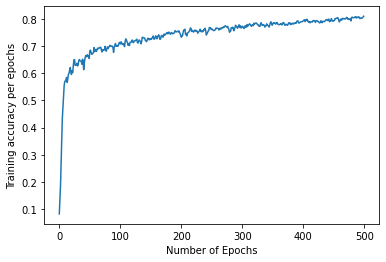

In [25]:
#plotting the training accuracy of the model
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.xlabel("Number of Epochs")
plt.ylabel('Training accuracy per epochs')
plt.show()

In [34]:
# # evaluate the model
# accuracy = model.evaluate(input_sequences, labels, verbose=0)
# print(f'Accuracy:{int(max(accuracy))}%')

## Text Prediction. A seed text to start the predicted proverbs is preprocessed exactly as the training data is 

In [35]:
def generate_proverbs(seed_text,next_words):
    """ A function that takes a 
    seed_text: to prompt next word prediction
    next_word: The number of next words to predict
    and returns the predicted yoruba proverbs"""
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        classes=np.argmax(predicted,axis=1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == classes:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

## Generate yoruba proverbs

In [36]:
data[34:38]

['ìṣeǹṣe ewúrẹ kágùntàn fiyè síi',
 'àgbà kì í ṣorò bí èwe',
 'iṣú ta iṣu ò ta ọkọọkan là ńwúṣu lébè',
 'ìtórò tó so lóko tí kò fẹhìntì afẹfẹ oko ní ńtú u']

In [37]:
generate_proverbs('obìnrin',10)

'obìnrin tí yó fẹẹ alágbára ọkàn kan ní ńpa ńṣe oko'

In [38]:
alist = ['ńwúṣu','àgbà','ewúrẹ']
for word in alist:
  print(generate_proverbs(word,10))

ńwúṣu ńlá lè ò ńlù ú lọsànán ní bí a bá
àgbà tó bá na ọyẹkú á ríjà ogbè pa bọ sílé
ewúrẹ ńṣọdún àgùtán gbàlù sẹhìn òbúkọọ ní ká sin òun lọ


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
##How to save and load the model with tf.keras
model.save("/content/gdrive/My Drive/yoruba_proverbs_generator_model_lstm_400.h5")
model = tf.keras.models.load_model('/content/gdrive/My Drive/yoruba_proverbs_generator_model_lstm_400.h5')

In [ ]:
# Reset model 
from keras import backend as K
del model
K.clear_session()
tf.compat.v1.reset_default_graph()